#!/usr/bin/env python

coding: utf-8

# Tutorial on the implementation of cooling crystallizers in PharmaPy

In this tutorial, we will set up a crystallization unit.

For more information on the kinetic mechanisms and driving forces, see the problem statement included for the crystallization parameter estimation and design project.

```## Add some math mechanisms here anyways```


Given this information, you will be tasked with filling in the missing code below.

## Import Libraries
First, we import all the libraries. Today we are importing the important libraries for batch crystallization.


In [1]:
# Standard library imports
import numpy as np

# add PharmaPy package to python path
import sys
sys.path.append(r"C:\Users\jjper\Documents\RESEARCH\takeda\PharmaPy\PharmaPy-master")

##### PharmaPy imports #####
from PharmaPy.Phases import LiquidPhase, SolidPhase
from PharmaPy.Kinetics import CrystKinetics
from PharmaPy.Crystallizers import BatchCryst
from PharmaPy.Interpolation import PiecewiseLagrange

Could not find GLIMDA.


Now that we've imported the packages we need, we can start inputting kinetics information for the crystallizer. Here we supply kinetics with PharmaPy-friendly units for all parameters. As a reminder, the parameters for PharmaPy for primary and secondary nucleation, as well as growth and dissolution are shown above in the tutorial description.

## Kinetics

In [2]:
# Primary nucleation kinetic parameters (k_p, Ea_p, p)
prim = (3e8, 0, 3)  # kP in #/m3/s
# Secondary nucleation kinetic parameters (k_s, Ea_s, s_1, s_2)
sec = (4.46e10, 0, 2, 1)
# Crystal growth kinetic parameters (k_g, Ea_g, g)
growth = (5, 0, 1.32)  # kG in um/s



Another pivotal piece of crystallization kinetics is the solubility curve of the solute. In PharmaPy, we have a couple input representations for solubility, but the easiest input is a polynomial for of T, as shown in the tutorial description above.

Since we have all the pieces required for the kinetics object, we can also define that object using these kinetic parameter and solubility data.



In [3]:
# Solubility constants for the solution in polynomial form (A + BT + CT^2)
solub_cts = [1.45752618e+01, -9.98982300e-02,  1.72100000e-04]

# Creating a kinetics object using the kinetic and solubility data
kinetics = CrystKinetics(solub_cts, nucl_prim=prim, nucl_sec=sec,
                         growth=growth)


With all the kinetics defined, we can start defining a crystallization unit, just like how we have been defining reactors and filters throughout this course. We need a LiquidPhase object as well as a SolidPhase object similar to the Filter definition.

## Batch Cooling Crystallization

We first will explore the batch cooling crystallizer. For this unit, we also need a temperature profile that will be followed during operation, which will affect crystal size disctribution properties.


In [5]:
# Always must define the path to the physical properties of
# the species in the system.
path = 'compounds_mom.json'

# Temperature endpoints
temp_init = 323.15  # K
temp_final = 290.0  # K

# Intermediate temperature values for a
# linear cooling profile
temp_vals = [320, 310, 310, 305, 290]

# Let's specify a temps array to pass
# to the PiecewiseLagrange function.

# Here, the format will be a matrix
# with each row representing the two
# points for each linear segment. See
# below:
temps = np.array([[temp_init, temp_vals[0]],  # We go from the initial temperature to the first int temp
                  [temp_vals[0], temp_vals[1]],  # Next from int temp 1 to int temp 2
                  [temp_vals[1], temp_vals[2]],  # Etc...
                  [temp_vals[2], temp_vals[3]],
                  [temp_vals[3], temp_vals[4]],
                  [temp_vals[4], temp_final]], dtype=np.float64)  # Finish at final temp from the last int temp

# Initial Liquid characteristics
conc_init = kinetics.get_solubility(temp_init)  # kg/m**3
conc_init = (conc_init, 0)  # API conc and 0 for the solvent.

# Define the liquid phase for the crystallizer
liquid = LiquidPhase(path, temp=temp_init, vol=0.1, mass_conc=conc_init,)
                    # ind_solv=-1)

# Solid Characteristics (all API, 0 for the solvent)
massfrac_solid = (1, 0)

x_distrib = np.arange(1, 501)
distrib = np.zeros_like(x_distrib)
solid = SolidPhase(path, temp_init, mass_frac=massfrac_solid,
                   distrib=distrib, x_distrib=x_distrib)

# ---------- Control Setup
time_final = 3600

# Specify the linear temperature function (order 2)
interpolator = PiecewiseLagrange(time_final, y_vals=temps,
                                 order=2)

controls = {'temp': interpolator.evaluate_poly}

# ---------- Unit operation definition
CR01 = BatchCryst(target_comp='solute', method='moments',
                  controls=controls)

# Connect kinetics and phases to the unit operation
CR01.Kinetics = kinetics
CR01.Phases = (liquid, solid)

# ---------- Solve model
results = CR01.solve_unit(time_final, verbose=True)

Final Run Statistics: --- 

 Number of steps                                 : 517
 Number of function evaluations                  : 647
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 91
 Number of error test failures                   : 18
 Number of nonlinear iterations                  : 644
 Number of nonlinear convergence failures        : 5

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 3600.0 seconds.
Elapsed simulation time: 0.10329910000000098 seconds.


In [6]:
results

([0.0,
  0.12356132633577006,
  0.20745930839879229,
  0.29135729046181447,
  0.3752552725248367,
  0.5013201797560243,
  0.6273850869872118,
  0.7534499942183994,
  0.94924397603548,
  1.1450379578525607,
  1.3408319396696413,
  1.536625921486722,
  1.7324199033038026,
  1.9282138851208832,
  2.255022638932607,
  2.581831392744331,
  2.908640146556055,
  3.235448900367779,
  3.562257654179503,
  3.8890664079912267,
  4.215875161802951,
  4.786030694251483,
  5.356186226700015,
  5.926341759148547,
  6.49649729159708,
  7.066652824045612,
  7.636808356494144,
  8.72837936734522,
  9.819950378196296,
  10.911521389047373,
  12.00309239989845,
  13.094663410749526,
  14.186234421600602,
  15.277805432451679,
  16.369376443302755,
  17.460947454153832,
  18.55251846500491,
  19.644089475855985,
  20.73566048670706,
  21.827231497558138,
  22.918802508409215,
  24.01037351926029,
  25.101944530111368,
  26.193515540962444,
  27.28508655181352,
  28.376657562664597,
  29.468228573515674,
  

### Plotting
A demonstration of some plotting capabilities with the CR01 object.

C:\Users\jjper\Documents\RESEARCH\takeda\PharmaPy\PharmaPy-master\PharmaPy\Crystallizers.py:1089: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend().remove()


(<Figure size 640x480 with 7 Axes>,
 array([[<Axes: ylabel='$\\mu_{0}$ (#)'>, <Axes: ylabel='$\\mu_{1}$ (m)'>],
        [<Axes: ylabel='$\\mu_{2}$ ($\\mathrm{m^{2}}$)'>,
         <Axes: ylabel='$\\mu_{3}$ ($\\mathrm{m^{3}}$)'>],
        [<Axes: ylabel='$T$ ($\\mathregular{K}$)'>,
         <Axes: ylabel='$C_{j}$ ($\\mathregular{kg \\ m^{-3}}$)'>]],
       dtype=object))

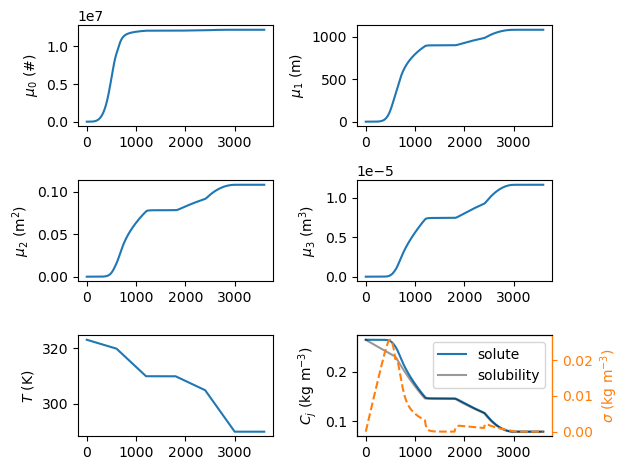

In [7]:
CR01.plot_profiles()

For this next section, we will have the same exact crystallizer, but set up with a a **quadratic cooling profile** instead of a linear one. We will heavily comment the new temperature profile construction.

*Note how I call the new crystallizer CR02. If you have more than one crystallizer in the same namespace, it is best to make unique names. Otherwise, some saved state data will carry over and make for some strange simulations.*


In [8]:
# Temperature endpoints
temp_init = 323.15  # K
temp_final = 290.0  # K

# Intermediate temperature values for a
# linear cooling profile
int_temp_val = 315

# Here we are only defining one decision to the
# quadratic profile. Similar to the linear case,
# we will provide 3 points for each lagrange segment
# since we are using a 2nd order polynomial. Since we
# only have one segment, we can simply use a list of
# the format: [initial temp, intermediate temp, final temp]
temps = [temp_init, int_temp_val, 311, temp_final]


# Initial Liquid characteristics
conc_init = kinetics.get_solubility(temp_init)  # kg/m**3
conc_init = (conc_init, 0)  # API conc and 0 for the solvent.

# Define the liquid phase for the crystallizer
liquid = LiquidPhase(path, temp=temp_init, vol=0.1, mass_conc=conc_init,)
                    # ind_solv=-1)

# Solid Characteristics (all API, 0 for the solvent)
massfrac_solid = (1, 0)

x_distrib = np.arange(1, 501)
distrib = np.zeros_like(x_distrib)
solid = SolidPhase(path, temp_init, mass_frac=massfrac_solid,
                   distrib=distrib, x_distrib=x_distrib)

# ---------- Control Setup
time_final = 3600

# Specify the quadratic temperature function (order 3)
interpolator = PiecewiseLagrange(time_final, y_vals=temps,
                                 order=4)

controls = {'temp': interpolator.evaluate_poly}

# ---------- Unit operation definition
CR02 = BatchCryst(target_comp='solute', method='1D-FVM',
                  controls=controls)

# Connect kinetics and phases to the unit operation
CR02.Kinetics = kinetics
CR02.Phases = (liquid, solid)

# ---------- Solve model
results = CR02.solve_unit(time_final, verbose=True)

Final Run Statistics: --- 

 Number of steps                                 : 2253
 Number of function evaluations                  : 3700
 Number of Jacobian*vector evaluations           : 2668
 Number of function eval. due to Jacobian eval.  : 3700
 Number of error test failures                   : 13
 Number of nonlinear iterations                  : 3697
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : SPGMR
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 3600.0 seconds.
Elapsed simulation time: 1.5195699000032619 seconds.


(<Figure size 640x480 with 7 Axes>,
 array([[<Axes: ylabel='$\\mu_{0}$ (#)'>, <Axes: ylabel='$\\mu_{1}$ (m)'>],
        [<Axes: ylabel='$\\mu_{2}$ ($\\mathrm{m^{2}}$)'>,
         <Axes: ylabel='$\\mu_{3}$ ($\\mathrm{m^{3}}$)'>],
        [<Axes: ylabel='$T$ ($\\mathregular{K}$)'>,
         <Axes: ylabel='$C_{j}$ ($\\mathregular{kg \\ m^{-3}}$)'>]],
       dtype=object))

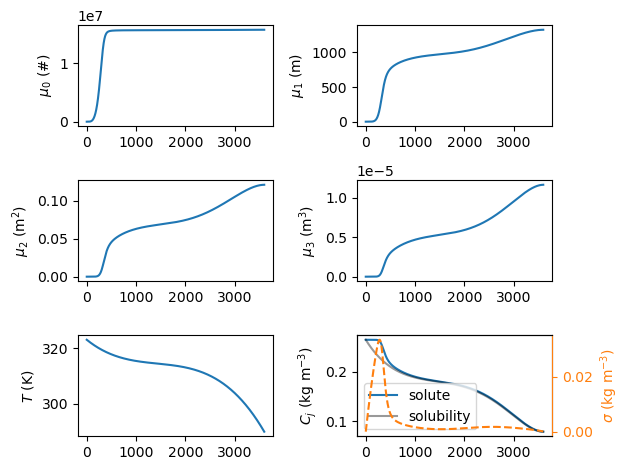

In [9]:
CR02.plot_profiles()

### Model Outputs

Finally, we may want to gather some outputs on the models, for instance mean particle size or size variance. (Since we are using the method of moments these are two of the general statistics we can use to perform optimization).



In [10]:
# Gathering the moments
moments = CR01.result.mu_n[-1]
moments2 = CR02.result.mu_n[-1]

# Computing mean size with low moments
mean_size = moments[1] / moments[0] * 1e6
mean_size2 = moments2[1] / moments2[0]* 1e6

# Computing coefficient of variance
coeff_var = np.sqrt(moments[2] * moments[0] / moments[1]**2 - 1)
coeff_var2 = np.sqrt(moments2[2] * moments2[0] / moments2[1]**2 - 1)

print('Mean size for linear profile is: {:.2f} microns'.format(mean_size))
print('Mean size for quadratic profile is: {:.2f} microns'.format(mean_size2))
print()
print('Coefficient of Variance for linear profile is: {:.2f}'.format(coeff_var))
print('Coefficient of Variance for quadratic profile is: {:.2f}'.format(coeff_var2))

Mean size for linear profile is: 88.78 microns
Mean size for quadratic profile is: 84.69 microns

Coefficient of Variance for linear profile is: 0.35
Coefficient of Variance for quadratic profile is: 0.27
